In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import pickle

In [5]:
'''
This notebook uses 0.24.2 version of sklearn
!pip uninstall scikit-learn -y

!pip install -U scikit-learn
'''

Found existing installation: scikit-learn 0.24.2
Uninstalling scikit-learn-0.24.2:
  Successfully uninstalled scikit-learn-0.24.2
  Using cached scikit_learn-0.24.2-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)


In [6]:
#change the url for your own dataset
url = '/content/drive/MyDrive/bike_clean.csv'
df = pd.read_csv(url)

In [7]:
df.head()

,Unnamed: 0,datetime,date,hour,season,holiday,open,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,1,2017-12-01 00:00:00,2017-12-01,0,Winter,No Holiday,Yes,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,2,2017-12-01 01:00:00,2017-12-01,1,Winter,No Holiday,Yes,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,3,2017-12-01 02:00:00,2017-12-01,2,Winter,No Holiday,Yes,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,4,2017-12-01 03:00:00,2017-12-01,3,Winter,No Holiday,Yes,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,5,2017-12-01 04:00:00,2017-12-01,4,Winter,No Holiday,Yes,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [8]:
df.columns

Index(['Unnamed: 0', 'datetime', 'date', 'hour', 'season', 'holiday', 'open',
       'rent_count', 'temperature', 'humidity', 'wind_speed', 'visibility',
       'dewpoint_temp', 'solar_radiation', 'rainfall', 'snowfall'],
      dtype='object')

In [9]:
# dropping the date columns and removing all rows where the bikes are not open
index_names = df[ df['open'] == "No" ].index
df.drop(index_names, inplace = True)
df.drop(columns = ["Unnamed: 0", "datetime", "hour", "open"], inplace = True)

In [10]:
columns = list(df.columns)
columns.remove('rent_count')
print(columns)

['date', 'season', 'holiday', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dewpoint_temp', 'solar_radiation', 'rainfall', 'snowfall']


In [11]:
df.head()

,date,season,holiday,rent_count,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation,rainfall,snowfall
0,2017-12-01,Winter,No Holiday,254,-5.2,37,2.2,20000,-17.6,0.0,0.0,0
1,2017-12-01,Winter,No Holiday,204,-5.5,38,0.8,20000,-17.6,0.0,0.0,0
2,2017-12-01,Winter,No Holiday,173,-6.0,39,1.0,20000,-17.7,0.0,0.0,0
3,2017-12-01,Winter,No Holiday,107,-6.2,40,0.9,20000,-17.6,0.0,0.0,0
4,2017-12-01,Winter,No Holiday,78,-6.0,36,2.3,20000,-18.6,0.0,0.0,0


In [12]:
# combining rows by days where rent count, rainfall and snowfall are summed, the rest are combined by median
df_per_day = df.groupby(["date", "season", "holiday"], as_index = False).median()
df_per_day.drop(columns = ["rainfall", "snowfall"], inplace = True)
other = df.groupby("date", as_index = False).agg({"rent_count":"sum", "rainfall" : "sum", "snowfall" : "sum"})
df_per_day.drop(columns = ["rent_count"], inplace = True)
df_per_day = other.merge(df_per_day, on = "date")

In [13]:
df_per_day.head()

,date,rent_count,rainfall,snowfall,season,holiday,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation
0,2017-12-01,9539,0.0,0,Winter,No Holiday,-1.10,37.5,1.4,20000.0,-17.40,0.0
1,2017-12-02,8523,0.0,0,Winter,No Holiday,2.70,55.5,1.6,14410.0,-5.55,0.0
2,2017-12-03,7222,4.0,0,Winter,No Holiday,4.35,84.5,1.6,3380.0,2.65,0.0
3,2017-12-04,8729,0.1,0,Winter,No Holiday,-0.25,43.5,3.6,19130.0,-12.95,0.0
4,2017-12-05,8307,0.0,0,Winter,No Holiday,-3.80,34.5,0.0,20000.0,-17.70,0.0


In [14]:
df_per_day.drop(columns = ["date"], inplace = True)

# X is the variables and y is the response
X = df_per_day.iloc[:, df_per_day.columns != "rent_count"]
y = df_per_day.iloc[:, df_per_day.columns == "rent_count"]

In [15]:
X.head()

,rainfall,snowfall,season,holiday,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation
0,0.0,0,Winter,No Holiday,-1.10,37.5,1.4,20000.0,-17.40,0.0
1,0.0,0,Winter,No Holiday,2.70,55.5,1.6,14410.0,-5.55,0.0
2,4.0,0,Winter,No Holiday,4.35,84.5,1.6,3380.0,2.65,0.0
3,0.1,0,Winter,No Holiday,-0.25,43.5,3.6,19130.0,-12.95,0.0
4,0.0,0,Winter,No Holiday,-3.80,34.5,0.0,20000.0,-17.70,0.0


In [16]:
# one hot encoding categorical variables

categorical_X = X.iloc[:, [2,3]]
continuous_X = X.iloc[:, [0,1] + list(range(4,10))]

categorical_encoder = OneHotEncoder(handle_unknown = "ignore")
ct = ColumnTransformer(
    transformers = [("Categorical", categorical_encoder, [0, 1])]
    , remainder = 'drop'
)
categorical_X = ct.fit_transform(categorical_X)
categorical_label = ct.get_feature_names()
categorical_X = pd.DataFrame(categorical_X, columns = categorical_label)

In [17]:
X = categorical_X.merge(continuous_X, left_index = True, right_index = True)

In [18]:
X.head()

,Categorical__x0_Autumn,Categorical__x0_Spring,Categorical__x0_Summer,Categorical__x0_Winter,Categorical__x1_Holiday,Categorical__x1_No Holiday,rainfall,snowfall,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,-1.10,37.5,1.4,20000.0,-17.40,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,2.70,55.5,1.6,14410.0,-5.55,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,4.0,0,4.35,84.5,1.6,3380.0,2.65,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.1,0,-0.25,43.5,3.6,19130.0,-12.95,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,-3.80,34.5,0.0,20000.0,-17.70,0.0


# Decision Tree (Random Forest)

## Splitting the data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)
X_column_names = X_train.columns # just keeping track of the column names

In [20]:
X_train

,Categorical__x0_Autumn,Categorical__x0_Spring,Categorical__x0_Summer,Categorical__x0_Winter,Categorical__x1_Holiday,Categorical__x1_No Holiday,rainfall,snowfall,temperature,humidity,wind_speed,visibility,dewpoint_temp,solar_radiation
101,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,7.30,46.5,1.05,7910.0,-4.60,0.015
202,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,24.05,45.0,2.00,18450.0,9.65,0.290
329,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,11.70,75.0,1.10,6595.0,5.10,0.000
181,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,22.70,43.5,1.75,17660.0,9.90,0.505
82,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,-1.70,31.0,2.20,19975.0,-17.70,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1.60,57.5,2.85,5870.0,-4.80,0.000
106,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,6.70,50.5,1.35,17775.0,-5.35,0.030
270,0.0,0.0,1.0,0.0,0.0,1.0,9.5,0,24.90,77.5,1.85,10520.0,22.20,0.020
348,1.0,0.0,0.0,0.0,0.0,1.0,0.0,29,5.80,70.5,1.10,4675.0,1.00,0.000


## Training the model

In [21]:
model = RandomForestRegressor(random_state = 42)
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(random_state=42)

In [22]:
np.mean(cross_val_score(model, X_train, np.ravel(y_train,order="c"), cv=10))

0.887152126803372

##Checking the error between prediction and test value

In [23]:
y_pred = model.predict(X_test)

In [24]:
print('Explained Variance Score:', metrics.explained_variance_score(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R Squared Score:', (metrics.r2_score(y_test, y_pred)))

Explained Variance Score: 0.8795512383410281
Mean Squared Error: 13241175.792887324
R Squared Score: 0.8788764678189456


##Finding the important features

In [25]:
#sorting them
sorted_features = []
for feature, importance in zip(X.columns, model.feature_importances_):
    sorted_features.append((feature, importance))
sorted_features.sort(key = lambda x: x[1], reverse = True)

In [26]:
sorted_features

[('temperature', 0.636368872124411),
 ('rainfall', 0.1465560249765643),
 ('solar_radiation', 0.046895047064951324),
 ('humidity', 0.04415906502342733),
 ('Categorical__x0_Autumn', 0.03949191717059441),
 ('Categorical__x0_Winter', 0.035771400800922136),
 ('wind_speed', 0.015379821226456106),
 ('visibility', 0.014296212548837157),
 ('dewpoint_temp', 0.01212170245709346),
 ('Categorical__x0_Spring', 0.005226728345848616),
 ('Categorical__x0_Summer', 0.0014805382307177416),
 ('Categorical__x1_Holiday', 0.0008167375827013661),
 ('Categorical__x1_No Holiday', 0.000788161288114029),
 ('snowfall', 0.0006477711593610506)]

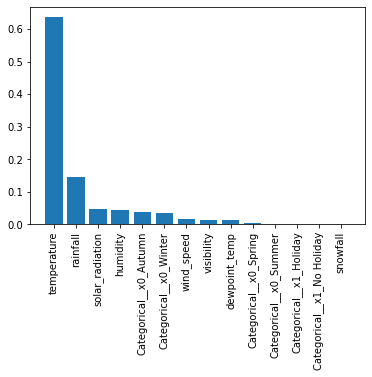

In [27]:
plt.bar([x[0] for x in sorted_features], [y[1] for y in sorted_features])
plt.xticks(rotation='vertical')
plt.show()

[Text(685.0446428571428, 978.48, 'temperature <= 8.95\nmse = 93168871.083\nsamples = 179\nvalue = 18708.635'),
 Text(373.6607142857143, 761.0400000000001, 'Categorical__x0_Autumn <= 0.5\nmse = 27397173.61\nsamples = 70\nvalue = 8972.368'),
 Text(199.28571428571428, 543.6, 'solar_radiation <= 0.002\nmse = 8391673.666\nsamples = 58\nvalue = 6842.819'),
 Text(99.64285714285714, 326.1600000000001, 'temperature <= -1.725\nmse = 3911396.806\nsamples = 46\nvalue = 5742.8'),
 Text(49.82142857142857, 108.72000000000003, '\n  (...)  \n'),
 Text(149.46428571428572, 108.72000000000003, '\n  (...)  \n'),
 Text(298.92857142857144, 326.1600000000001, 'visibility <= 12037.5\nmse = 4421751.21\nsamples = 12\nvalue = 10815.111'),
 Text(249.10714285714283, 108.72000000000003, '\n  (...)  \n'),
 Text(348.75, 108.72000000000003, '\n  (...)  \n'),
 Text(548.0357142857142, 543.6, 'rainfall <= 6.05\nmse = 20559305.671\nsamples = 12\nvalue = 16657.261'),
 Text(498.21428571428567, 326.1600000000001, 'dewpoint_te

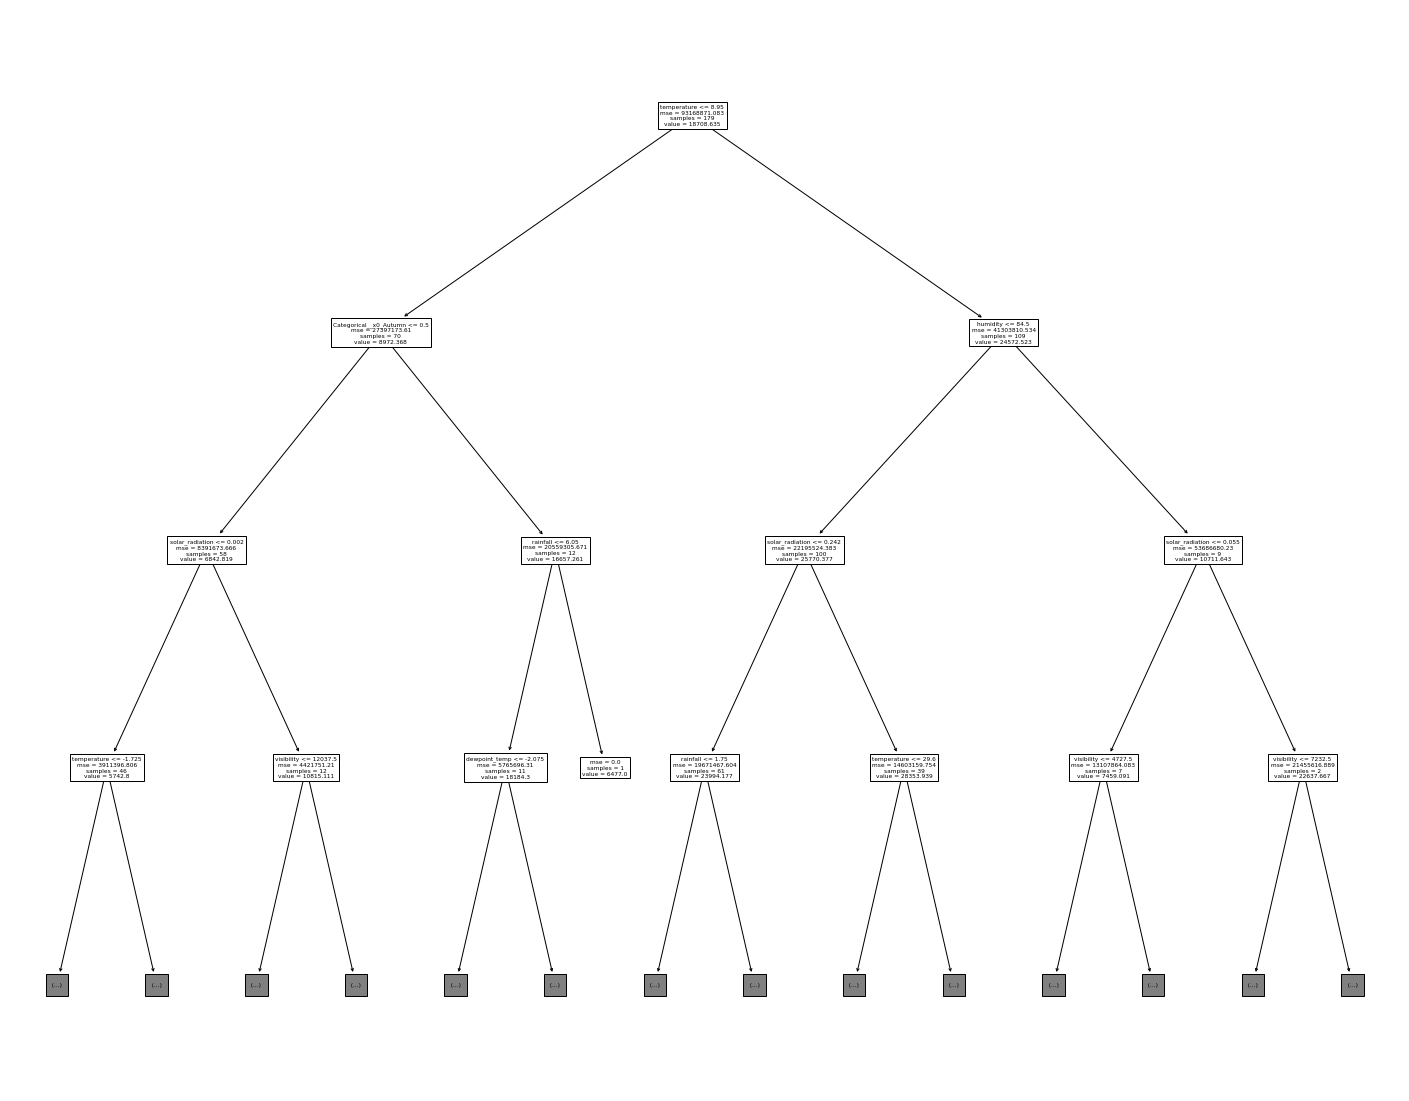

In [38]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
tree.plot_tree(model.estimators_[0], max_depth = 3, feature_names = X_train.columns)

# Parameter Tuning

In [29]:
n_estimators = np.arange(100, 2000, step=100)
max_features = ["auto", "sqrt", "log2"]
max_depth = list(np.arange(10, 100, step=10)) + [None]
min_samples_split = np.arange(2, 10, step=2)
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

In [30]:
forest = RandomForestRegressor(random_state = 42)
random_cv = RandomizedSearchCV(
    forest, param_grid, n_iter=100, cv=3, scoring= "neg_mean_absolute_percentage_error"
)

In [32]:
_ = random_cv.fit(X_train, y_train)
print("Best params:\n")
print(random_cv.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 

Best params:

{'n_estimators': 900, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


In [33]:
tuned_model = RandomForestRegressor(n_estimators = 100, min_samples_split = 2, min_samples_leaf = 1, max_features = "auto", max_depth = 80, bootstrap = True)

In [34]:
np.mean(cross_val_score(tuned_model, X_train, np.ravel(y_train,order="c"), cv=10))

0.884658516067549

In [36]:
pip install shap

     |████████████████████████████████| 356 kB 26.0 MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491662 sha256=b69359afc44e8c9dbbad9620a816ecbf2cc330493501c6ce8d8095afb22c9cf4
  Stored in directory: /root/.cache/pip/wheels/ca/25/8f/6ae5df62c32651cd719e972e738a8aaa4a87414c4d2b14c9c0
Successfully built shap


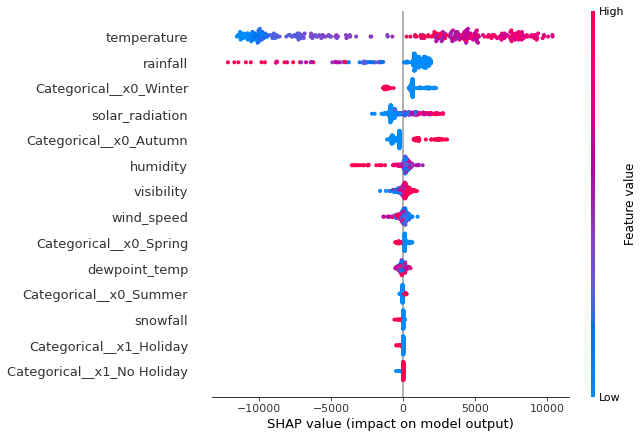

In [37]:
import shap
shap.initjs()

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value[0], shap_values[3,:], X_train_c1.iloc[3,:])

shap.summary_plot(shap_values, X_train)

#Saving / Loading the model

In [ ]:
pkl_filename = "pickle_model.pkl"
file_directory = 'Add the path of your google drive folder'

# Save to file in the current working directory
#with open(file_directory + pkl_filename, 'wb') as file:
    #pickle.dump(model, file)

# Load from file
with open(file_directory + pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)